# SUPERVISED GRAPH CLASSIFICATION with GNN - Deep Graph Library

Rebecca Casati

AI Models for Physics Exam

## Preliminary

In [1]:
# Choose if importing the dataset directly from DGL or convert it after importing it with PyG:
import_from_pyg = False     # False if dataset is imported direclty with DGL

# Choose if saving the figures on Google Drive or not:
save_gdrive = False

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!pip install  -q dgl -f https://data.dgl.ai/wheels/cu121/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00


In [4]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
import networkx as nx
import numpy as np
import torch
import torch.nn as nn

In [5]:
if import_from_pyg:
  os.environ['TORCH'] = torch.__version__

  !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
  !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
  !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [6]:
if save_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

Selected device: cuda


## Dataset

[**TUDatasets**](https://chrsmrrs.github.io/datasets/), in DGL: [`dgl.data.TUDataset`](https://docs.dgl.ai/en/1.1.x/generated/dgl.data.TUDataset.html#dgl.data.TUDataset)

*NOTE: TUDataset is the only one available both directly from PyG and DGL for graph classification*

In [8]:
dataset_str = 'MUTAG'
# dataset_str = 'Mutagenicity'
# dataset_str = 'MOLT-4'

if not import_from_pyg: # import directly the dataset with DGL
  dataset = dgl.data.TUDataset(dataset_str)
else:   # if the dataset is imported with PyG and then converted to DGL
  from torch_geometric.datasets import TUDataset
  pyg_dataset = TUDataset(root='data/TUDataset', name=dataset_str)
  # convert the dataset from PyG to DGL
  dgl_dataset = []  # list that will contain the DGL dataset
  for i in range(len(pyg_dataset)):
      pyg_graph = pyg_dataset[i]
      num_nodes = pyg_graph.num_nodes
      dgl_graph = dgl.DGLGraph()
      dgl_graph.add_nodes(num_nodes)
      dgl_graph.add_edges(pyg_graph.edge_index[0], pyg_graph.edge_index[1])
      dgl_graph.ndata['node_labels'] = pyg_graph.x
      dgl_graph.edata['edge_labels'] = pyg_graph.edge_attr
      dgl_dataset.append((dgl_graph, pyg_graph.y))
  dataset = dgl_dataset

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
if not import_from_pyg:
  num_classes = dataset.num_classes
else:
  classes = []
  for _, label in dataset:
    classes.append(label.item())
  num_classes = len(np.unique(classes))
print(f'Number of classes: {num_classes}')

Extracting file to /root/.dgl/MUTAG_47395044

Dataset: Dataset("MUTAG", num_graphs=188, save_path=/root/.dgl/MUTAG_47395044):
Number of graphs: 188
Number of classes: 2


Inspect one graph of the dataset:

*NOTE: here the dataset is loaded with as node features just scalars (in PyG the node features are vectors of 7-14-64 elements).*

*NOTE: the elements of the dataset here are tuples of two elements - the graph and the label associated to it are two different objects (in PyG instead I have just one object that also contains the label of the graph).*

In [9]:
print("One element of the dataset is saved as: ", type(dataset[0]))
print("The graph object type is: ", type(dataset[0][0]))

One element of the dataset is saved as:  <class 'tuple'>
The graph object type is:  <class 'dgl.heterograph.DGLGraph'>


In [10]:
g, label = dataset[0]  # Get the first graph object.

print(g)
print(label.item())       # label of the graph (class)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {g.num_nodes()}')
print(f'Number of edges: {g.num_edges()}')
print(f'Average node degree: {g.num_edges() / g.num_nodes():.2f}')
isolated_nodes = (g.in_degrees() == 0) & (g.out_degrees() == 0)
print(f'Has isolated nodes: {isolated_nodes.any().item()}')
edges_self_loops = (g.edges()[0] == g.edges()[1]).nonzero()
has_self_loops = len(edges_self_loops) > 0
print(f'Has self-loops: {has_self_loops}')
print(f'Is directed: {g.is_block}')

Graph(num_nodes=17, num_edges=38,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'edge_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})
1
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is directed: False


Print the graph (conversion to NetworkX):

*NOTE: dgl.to_networkx does not support graph_attrs as input.*

Number of nodes: 17
Number of edges: 38
Node features:  [(0, {'node_labels': tensor([0])}), (1, {'node_labels': tensor([0])}), (2, {'node_labels': tensor([0])}), (3, {'node_labels': tensor([0])}), (4, {'node_labels': tensor([0])}), (5, {'node_labels': tensor([0])}), (6, {'node_labels': tensor([0])}), (7, {'node_labels': tensor([0])}), (8, {'node_labels': tensor([0])}), (9, {'node_labels': tensor([0])}), (10, {'node_labels': tensor([0])}), (11, {'node_labels': tensor([0])}), (12, {'node_labels': tensor([0])}), (13, {'node_labels': tensor([0])}), (14, {'node_labels': tensor([1])}), (15, {'node_labels': tensor([2])}), (16, {'node_labels': tensor([2])})]
Edge features:  [(0, 1, {'id': 0, 'edge_labels': tensor([0])}), (0, 5, {'id': 1, 'edge_labels': tensor([0])}), (1, 0, {'id': 2, 'edge_labels': tensor([0])}), (1, 2, {'id': 3, 'edge_labels': tensor([0])}), (2, 1, {'id': 4, 'edge_labels': tensor([0])}), (2, 3, {'id': 5, 'edge_labels': tensor([0])}), (3, 2, {'id': 6, 'edge_labels': tensor([0]

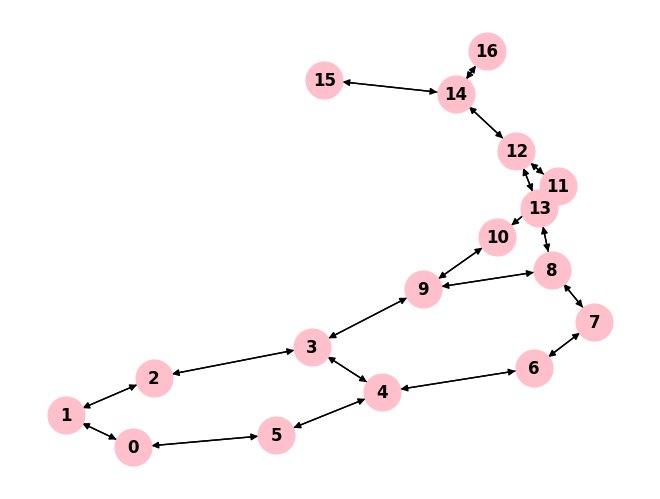

In [11]:
from dgl import to_networkx

G = to_networkx(g, node_attrs=["node_labels"], edge_attrs=["edge_labels"])
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
#print("Graph feature: ", G.graph)
num_node_features =  G.nodes.data()
print("Node features: ", G.nodes.data())
print("Edge features: ", G.edges.data())
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='pink')

## Training

### Mini-batching

Shuffle the dataset and divide it into training set and test set:

In [12]:
from dgl.data.utils import split_dataset

torch.manual_seed(12345)
train_dataset, test_dataset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=12345)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


Batch the graphs:

In [13]:
from dgl.dataloading import GraphDataLoader

batch_size = 64
train_loader = GraphDataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = GraphDataLoader(test_dataset, batch_size = batch_size, shuffle = False)

for i, (batched_graph, labels) in enumerate(train_loader):
    num_graphs_in_batch = batched_graph.batch_size
    print(f"Mini-batch {i + 1}, Number of graphs in the current batch: {num_graphs_in_batch}")

Mini-batch 1, Number of graphs in the current batch: 64
Mini-batch 2, Number of graphs in the current batch: 64
Mini-batch 3, Number of graphs in the current batch: 22


Explore the dataloader:

*NOTE: the mini-batching in DGL gives as output a graph object to represent all the graphs put toghether in the batch + the array of graph labels as a completely different object.*

In [14]:
for batched_graph, labels in train_loader:
    num_node_features = batched_graph.ndata["node_labels"].shape[1]
    print("the dimensionality of the node-features is: ", num_node_features)
    print("batched_graph = ", batched_graph)
    print("labels = ", labels.squeeze(1))

the dimensionality of the node-features is:  1
batched_graph =  Graph(num_nodes=1179, num_edges=2614,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'edge_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})
labels =  tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])
the dimensionality of the node-features is:  1
batched_graph =  Graph(num_nodes=1115, num_edges=2452,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'edge_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})
labels =  tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
 

### Model

Define the model (Convolutional layer: [`GraphConv`](https://docs.dgl.ai/en/1.1.x/generated/dgl.nn.pytorch.conv.GraphConv.html)):

*NOTE: [`AvgPooling`](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.glob.AvgPooling.html) of DGL does the exact same as [`global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html) of PyG, but here you don't even have to specify the batch.*

In [20]:
from dgl.nn import GraphConv
from dgl.nn.pytorch.glob import AvgPooling
from torch.nn import Linear

class GNNdgl(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GNNdgl, self).__init__()
        torch.manual_seed(12345)
        # GraphConv layer <-> same as GCNConv (PyG)
        self.gcn_0 = GraphConv(num_node_features, hidden_channels, allow_zero_in_degree=True)
        self.gcn_h1 = GraphConv(hidden_channels, hidden_channels, allow_zero_in_degree=True)
        self.gcn_h2 = GraphConv(hidden_channels, hidden_channels, allow_zero_in_degree=True)
        self.avg_pooling = AvgPooling()
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, g, features):
        x = self.gcn_0(g, features)
        x = torch.relu(x)
        x = self.gcn_h1(g, x)
        x = torch.relu(x)
        x = self.gcn_h2(g, x)
        x = self.avg_pooling(g, x)
        x = torch.dropout(x, p=0.5, train=self.training)
        x = self.lin(x)

        return x

model = GNNdgl(num_node_features, hidden_channels=64, num_classes = num_classes)
print(model)

GNNdgl(
  (gcn_0): GraphConv(in=1, out=64, normalization=both, activation=None)
  (gcn_h1): GraphConv(in=64, out=64, normalization=both, activation=None)
  (gcn_h2): GraphConv(in=64, out=64, normalization=both, activation=None)
  (avg_pooling): AvgPooling()
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Train and test

In [21]:
import time

times = []
for i in range(11):
  print("RUN N. ", i)
  start_time = time.time()

  model = GNNdgl(num_node_features, hidden_channels=64, num_classes=num_classes)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = torch.nn.CrossEntropyLoss()

  def train():
      model.train()
      total_loss = 0.0
      num_batches = 0
      for batched_graph, labels in train_loader:
          out = model(batched_graph.to(device), batched_graph.ndata['node_labels'].to(device))  # Perform a single forward pass.
          labels = labels.squeeze(dim=1)
          loss = criterion(out, labels.to(device))  # Compute the loss.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.
          num_batches +=1
          loss = loss.to("cpu")
          total_loss += loss.detach()
      mean_loss = total_loss/num_batches
      return mean_loss

  def test(loader):
      model.eval()
      correct = 0
      for batched_graph, labels in loader:  # Iterate in batches over the training/test dataset.
          out = model(batched_graph.to(device), batched_graph.ndata['node_labels'].to(device))
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          labels = labels.squeeze(dim=1)
          correct += int((pred == labels.to(device)).sum())  # Check against ground-truth labels
      return correct / len(loader.dataset)  # Derive ratio of correct predictions.

  losses = []
  train_accs = []
  test_accs = []
  n_epochs = 170
  epochs = range(1, n_epochs+1)
  for epoch in epochs:
      loss = train()
      losses.append(loss)
      train_acc = test(train_loader)
      train_accs.append(train_acc)
      test_acc = test(test_loader)
      test_accs.append(test_acc)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)
  print(f"Time of execution: {total_time:.4f} seconds")

RUN N.  0
Epoch: 001, Train Acc: 0.4133, Test Acc: 0.3158, Loss: 0.6987
Epoch: 002, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6928
Epoch: 003, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6829
Epoch: 004, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6840
Epoch: 005, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6655
Epoch: 006, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6574
Epoch: 007, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6619
Epoch: 008, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6599
Epoch: 009, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6584
Epoch: 010, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6479
Epoch: 011, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6375
Epoch: 012, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6263
Epoch: 013, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6366
Epoch: 014, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6269
Epoch: 015, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.6122
Epoch: 016, Train Acc: 0.6933, Test Acc: 0.5526, Loss: 0.613

## Results

Time of execution:

In [22]:
import numpy as np

for i in range(1, len(times)):
  print(f"RUN N.{i}: Time of execution: {times[i]:.4f} seconds = {(times[i])/60:.4f} minutes")

times.pop(0)
time_mean = np.mean(np.array(times))
time_std = np.std(np.array(times))/np.sqrt(10)
print("MEAN TIME: ", time_mean)
print("STD TIME: ", time_std)

RUN N.1: Time of execution: 8.5485 seconds = 0.1425 minutes
RUN N.2: Time of execution: 9.0541 seconds = 0.1509 minutes
RUN N.3: Time of execution: 9.1949 seconds = 0.1532 minutes
RUN N.4: Time of execution: 8.5046 seconds = 0.1417 minutes
RUN N.5: Time of execution: 8.8523 seconds = 0.1475 minutes
RUN N.6: Time of execution: 9.1965 seconds = 0.1533 minutes
RUN N.7: Time of execution: 9.0116 seconds = 0.1502 minutes
RUN N.8: Time of execution: 8.4048 seconds = 0.1401 minutes
RUN N.9: Time of execution: 8.8360 seconds = 0.1473 minutes
RUN N.10: Time of execution: 9.0436 seconds = 0.1507 minutes
MEAN TIME:  8.864695048332214
STD TIME:  0.08664509685557541


Plot the accuracies:

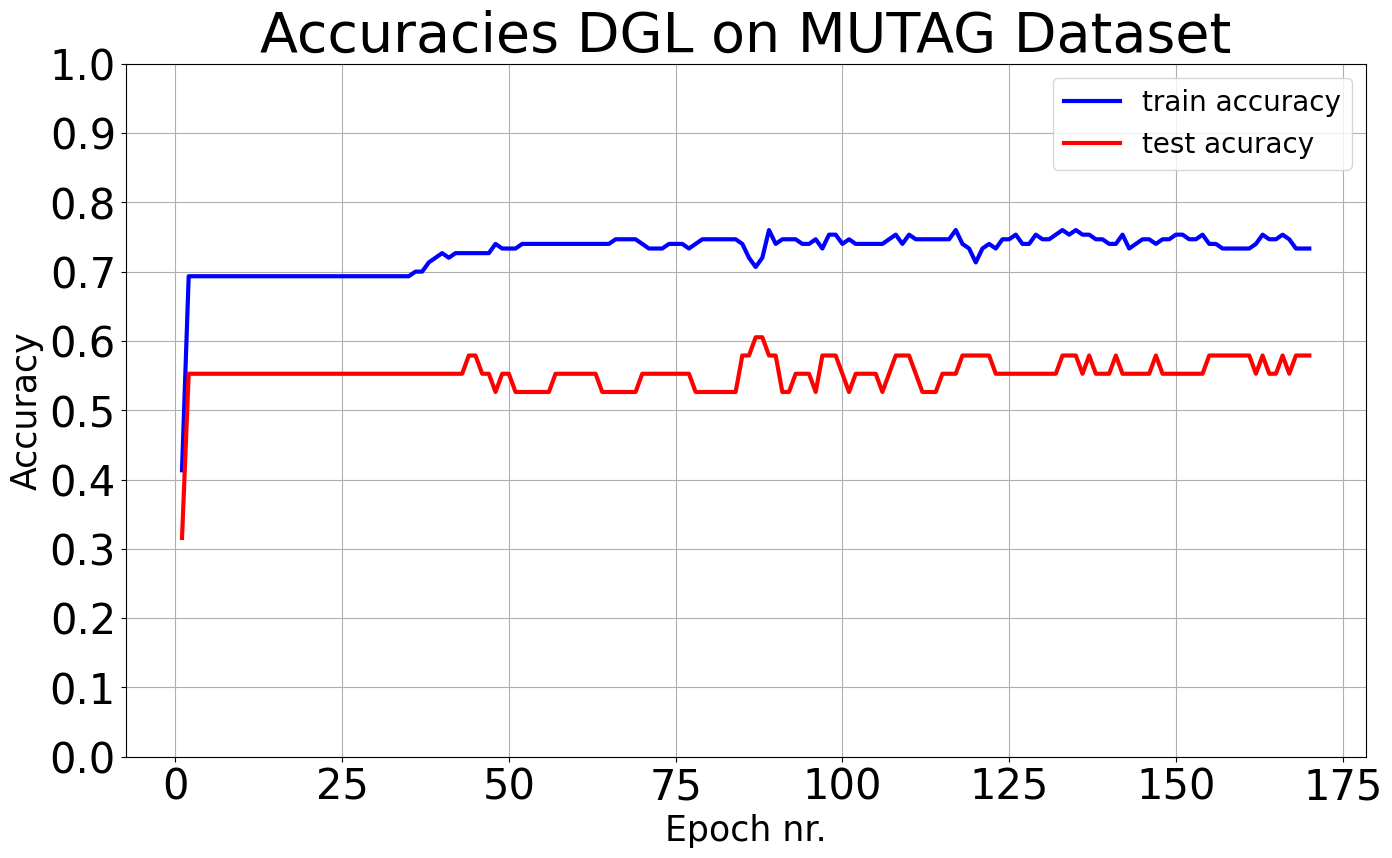

In [23]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (16,9))
plt.plot(epochs, train_accs, color = "blue", label = "train accuracy", lw = 3)
plt.plot(epochs, test_accs, color = "red", label = "test acuracy", lw = 3)
plt.xlabel("Epoch nr.", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.xticks(fontsize = 30)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 30)
plt.legend(fontsize = 20)
plt.grid()

if not import_from_pyg:
  plt.title("Accuracies DGL on " + dataset_str + " Dataset", fontsize = 40)
  if not save_gdrive:
    plt.savefig("Accuracies.png")
  else:
    plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Accuracies_DGL_" + dataset_str)
else:
  plt.title("Accuracies DGL on " + dataset_str + " Dataset - imported with PyG", fontsize = 40)
  if not save_gdrive:
    plt.savefig("Accuracies.png")
  else:
    plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Accuracies_DGL_" + dataset_str + "_from_PyG")

plt.show()

Plot the loss:

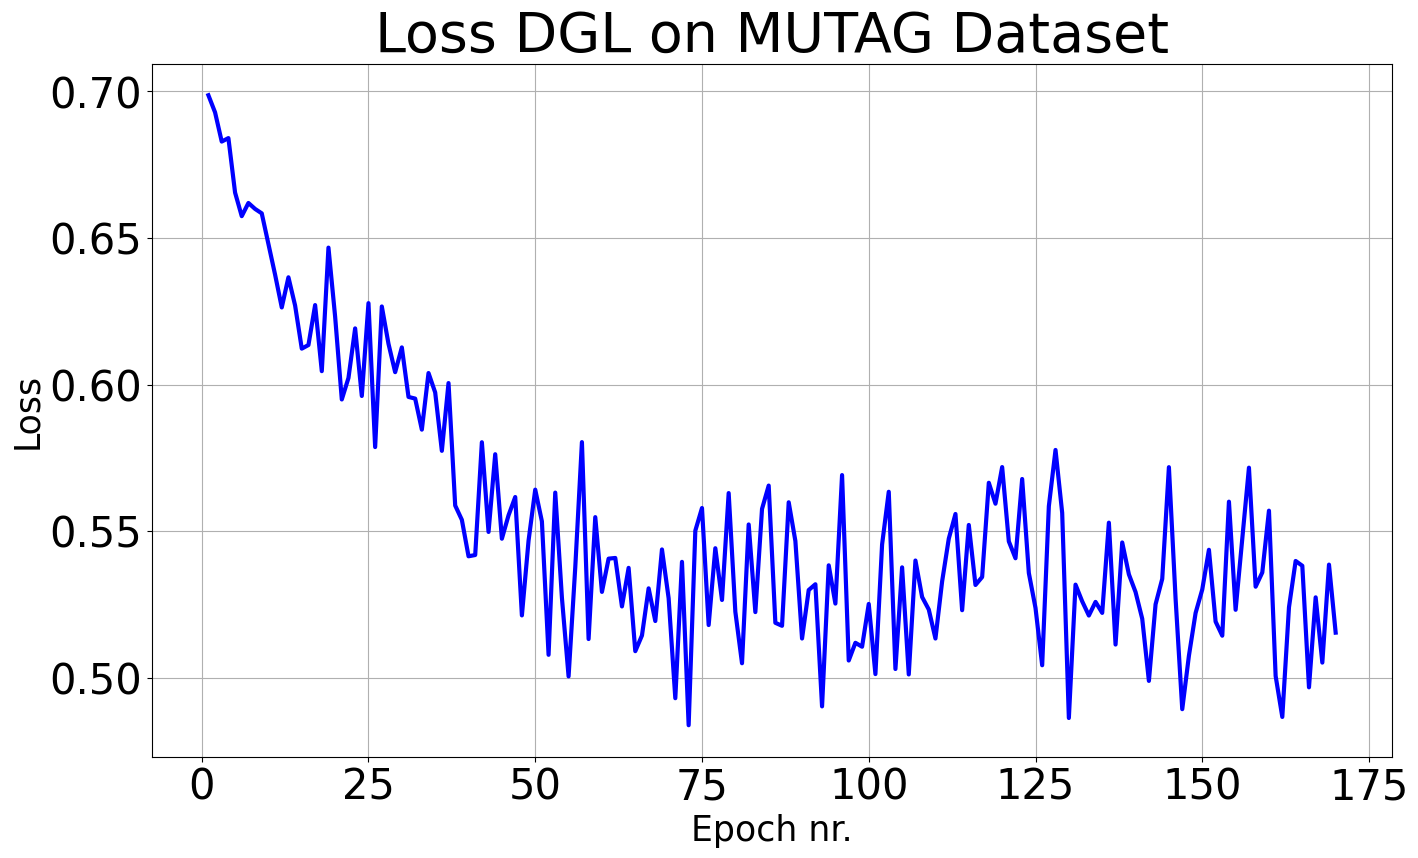

In [24]:
fig2 = plt.figure(figsize = (16,9))
plt.plot(epochs, losses, color = "blue", lw = 3)
plt.xlabel("Epoch nr.", fontsize = 25)
plt.ylabel("Loss", fontsize = 25)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid()

if not import_from_pyg:
  plt.title("Loss DGL on " + dataset_str + " Dataset", fontsize = 40)
  if not save_gdrive:
    plt.savefig("Loss.png")
  else:
    plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Loss_DGL_" + dataset_str)
else:
  plt.title("Loss DGL on " + dataset_str + " Dataset - imported with PyG", fontsize = 40)
  if not save_gdrive:
    plt.savefig("Loss.png")
  else:
    plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Loss_DGL_" + dataset_str + "_from_PyG")
plt.show()